Since we're doing a dijet analysis, we'll want to use TLorentzVectors to do things like computing the invariant mass of a two-jet system. But TLorentzVectors are notoriously slow in pyROOT. Even if this weren't the case, looping over big trees is really something you should never do in pyROOT. But pretty much everything besides those CPU-intensive tasks is better in pyROOT :-P

Please take a look at the minimal changes made to `hatsTrees.C` and `hatsTrees.h` that you can find in the `sample_code` directory. A good philosophy with using `TTree.MakeClass()` is to change as little as possible. Please read the below diff -- it contains useful tips on e.g. setting up the class to take arguments. Without the comments, there are about 30 lines of code added, but they're sufficient for all the heavy lifting in the calculation of complicated physical variables.

In [8]:
!diff --side-by-side hatsTrees.C sample_code/hatsTrees.C

#define hatsTrees_cxx						#define hatsTrees_cxx
#include "hatsTrees.h"						#include "hatsTrees.h"
#include <TH2.h>					      |	#include <TFile.h>
#include <TStyle.h>					      |	#include <TTree.h>
#include <TCanvas.h>					      |	#include <TLorentzVector.h>
							      >	#include <iostream>

void hatsTrees::Loop()					      |	/**     HATS comment
							      >	 * First we modify the Loop() method such that we can pass it
							      >	 * Also note that above, we added the includes want for basic
							      >	 * including TLorentzVectors, which are very slow in pyROOT
							      >	 */
							      >
							      >	void hatsTrees::Loop(std::string outFileName)
{								{
//   In a ROOT session, you can do:				//   In a ROOT session, you can do:
//      root> .L hatsTrees.C					//      root> .L hatsTrees.C
//      root> hatsTrees t					//      root> hatsTrees t
//      root> t.GetEntry(12); // Fill t data members with ent	//      root> t.GetEntry(12); // Fill t data members with 

In [7]:
!diff hatsTrees.h sample_code/hatsTrees.h

414c414,417
<    virtual void     Loop();
---
>    /**    HATS comment
>     * We have to modify the Loop() method declaration here too  
>     */
>    virtual void     Loop(std::string outFileName);


Now that we've prepared our C++ class to do the heavy lifting, we will create a python-environment script where we can load it and use it to process our big datasets, while leveraging python to do the things that are annoying in C++. We'll design it to be suitable for use in batch submissions. Please follow along by looking at sample_code/runHatsTrees.py 
> Now let's go through runHatsTrees.py

Note that runHatsTrees.py has an OptionParser defined. OptionParser is a commonly used bit of python that will automatically generate a help message for someone trying to use the script. Let's see what it says:

In [7]:
!python sample_code/runHatsTrees.py --help

Usage: runHatsTrees.py [options] arg

This script takes as input a directory of input .root files, and runs the hatsTrees.C macro on them.

Options:
  -h, --help            show this help message and exit
  -l, --load            do not recompile the class, instead load it from a
                        compiled library
  -i INDIR, --inDir=INDIR
                        the input directory of root files
  -t INTREENAME, --inTreeName=INTREENAME
                        the name of the input tree inside the input file
  -o OUTFILENAME, --outFileName=OUTFILENAME
                        the output root file name. It will be located within
                        the 'output' directory


Let's try running it according to the help message

In [15]:
!python sample_code/runHatsTrees.py -i /eos/uscms/store/user/hats/PyRoot/2017/qcd_samples/QCD_HT700to1000_0_0/ -o hatsTrees_QCD_HT700to1000_0_0.root -t "ntuplizer/tree"

In [16]:
!ls output

hatsTrees_QCD_HT700to1000_0_0.root


How much data did we just process?

In [17]:
!du -h --max-depth=2 /eos/uscms/store/user/hats/PyRoot/2017/qcd_samples/QCD_HT700to1000_0_0/

4.1G	/eos/uscms/store/user/hats/PyRoot/2017/qcd_samples/QCD_HT700to1000_0_0/


Let's make sure that our output looks reasonable.

In [25]:
import ROOT as r
firstHatsFile = r.TFile("output/hatsTrees_QCD_HT700to1000_0_0.root")
firstHatsFile.ls()

TFile**		output/hatsTrees_QCD_HT700to1000_0_0.root	
 TFile*		output/hatsTrees_QCD_HT700to1000_0_0.root	
  KEY: TTree	hatsDijets;1	hatsDijets


In [28]:
firstHatsTree = firstHatsFile.Get("hatsDijets")
firstHatsTree.Print()

******************************************************************************
*Tree    :hatsDijets: hatsDijets                                             *
*Entries :  1492382 : Total =        29947936 bytes  File  Size =   26947171 *
*        :          : Tree compression factor =   1.11                       *
******************************************************************************
*Br    0 :leadingEta : leadingEta/F                                          *
*Entries :  1492382 : Total  Size=    5989206 bytes  File Size  =    5542541 *
*Baskets :      188 : Basket Size=      32000 bytes  Compression=   1.08     *
*............................................................................*
*Br    1 :subleadingEta : subleadingEta/F                                    *
*Entries :  1492382 : Total  Size=    5989782 bytes  File Size  =    5546439 *
*Baskets :      188 : Basket Size=      32000 bytes  Compression=   1.08     *
*...................................................

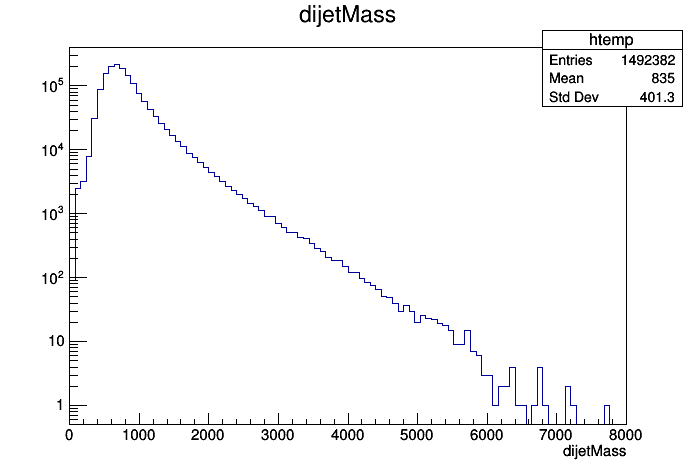

In [33]:
can = r.TCanvas()
can.SetLogy()
firstHatsTree.Draw("dijetMass")
can.Draw()

Now that we've seen that our python script works running over one of our input files, we're ready to do a batch submission to process all of our ntuples. However, during this HATS session, we won't actually submit the jobs. They have been made already and you can find them here:

In [34]:
!ls /eos/uscms/store/user/hats/PyRoot/2017/hatsDijetTrees/

hatsTrees_QCD_HT1000to1500  hatsTrees_QCD_HT200to300  hatsTrees_QCD_HT700to1000
hatsTrees_QCD_HT1500to2000  hatsTrees_QCD_HT300to500  hatsTrees_data
hatsTrees_QCD_HT2000toInf   hatsTrees_QCD_HT500to700  hatsTrees_sig


If you are interested in using a python script of this sort in batch submission, please see `sample_code/condorSubmission` for an example.

Please continue on in `backgroundHists.ipynb`.